In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Paths to data
cancer_dir = "data/unhealthy"
normal_dir = "data/healthy"


In [3]:
# Load filepaths and labels
filepaths = []
labels = []
for label, folder in zip(['cancer', 'normal'], [cancer_dir, normal_dir]):
    for file in os.listdir(folder):
        filepaths.append(os.path.join(folder, file))
        labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

labels
cancer    5504
normal    1008
Name: count, dtype: int64


C:\Users\vansh\AppData\Local\Temp\ipykernel_2012\3720759055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


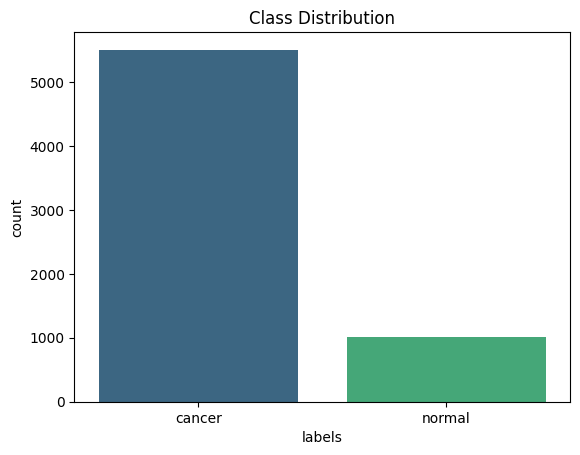

In [4]:
# Display dataset statistics
print(df['labels'].value_counts())
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Class Distribution")
plt.show()

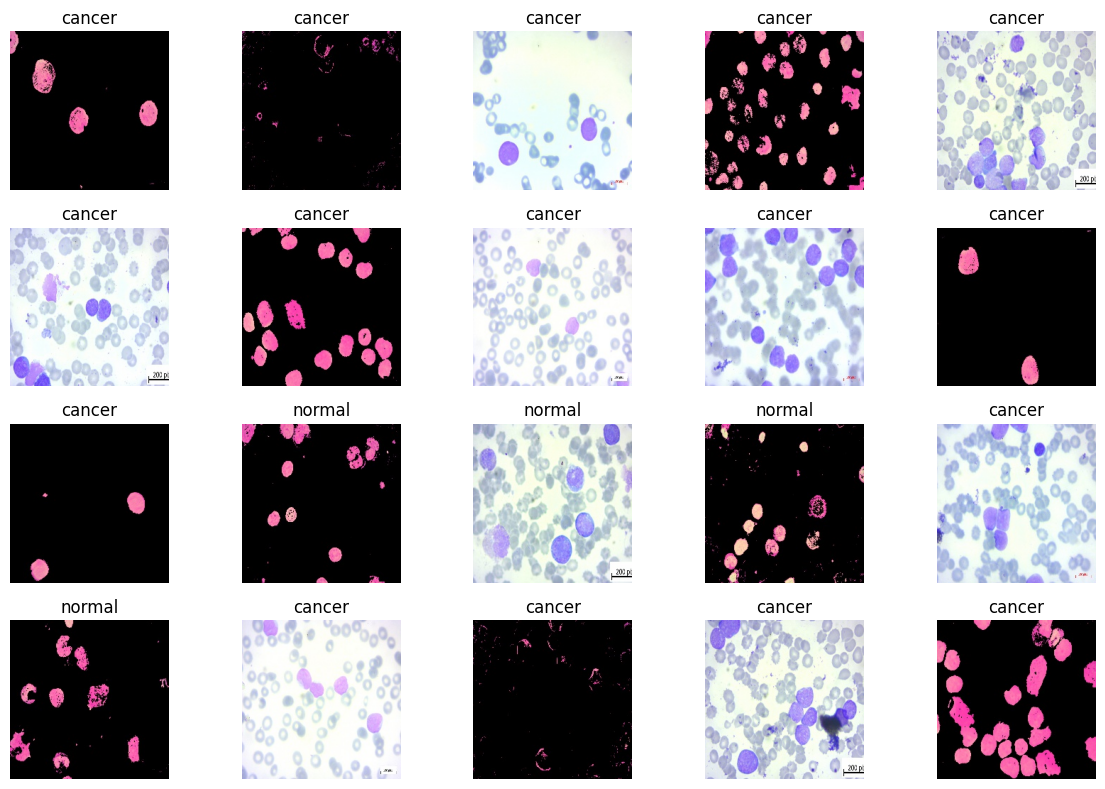

In [5]:
# Display sample images
plt.figure(figsize=(12, 8))
for i in range(20):
    random_idx = np.random.randint(len(df))
    img = cv2.imread(df['filepaths'].iloc[random_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(df['labels'].iloc[random_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# Preprocess the data
img_size = 150
X = []
y = []
for i, row in df.iterrows():
    img = cv2.imread(row['filepaths'], cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (img_size, img_size))
    X.append(resized_img)
    y.append(0 if row['labels'] == 'normal' else 1)

X = np.array(X) / 255.0  # Normalize images
X = X.reshape(-1, img_size * img_size)  # Flatten images
y = np.array(y)

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

In [8]:
# Build FFNN model
ffnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(img_size * img_size,)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

c:\Coding\Blood-Cancer-Detection\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
ffnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Train the model
history = ffnn_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=10, batch_size=32)


Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - accuracy: 0.7633 - loss: 5.7682 - val_accuracy: 0.8454 - val_loss: 0.5416
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.8412 - loss: 0.6062 - val_accuracy: 0.8454 - val_loss: 0.4350
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.8498 - loss: 0.4409 - val_accuracy: 0.8443 - val_loss: 0.4381
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.8416 - loss: 0.4842 - val_accuracy: 0.8443 - val_loss: 0.4386
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.8533 - loss: 0.4432 - val_accuracy: 0.8443 - val_loss: 0.4304
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.8531 - loss: 0.4171 - val_accuracy: 0.8454 - val_loss: 0.4302
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.8659 - loss: 0.3773 - val_accuracy: 0.8443 - val_loss: 0.4425
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.8577 - loss: 0

In [11]:
# Evaluate the model
test_loss, test_accuracy = ffnn_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.2f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8384 - loss: 0.4430
Test Accuracy: 0.84


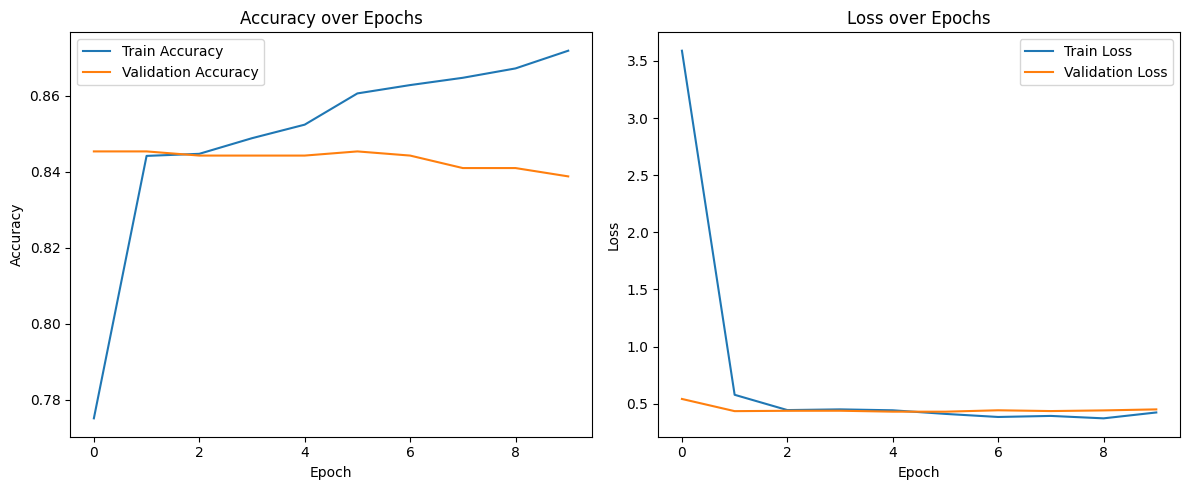

In [12]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Predictions
y_pred_probs = ffnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


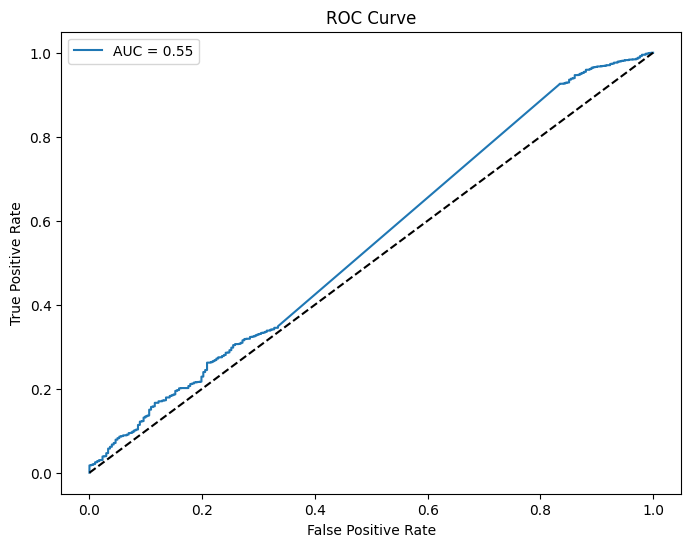

In [14]:
# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

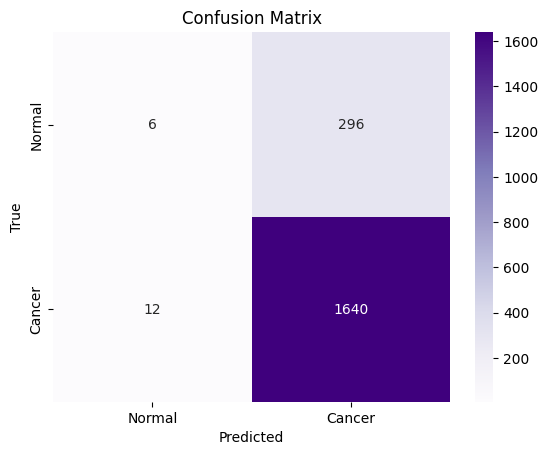

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Classification Report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Cancer']))

              precision    recall  f1-score   support

      Normal       0.33      0.02      0.04       302
      Cancer       0.85      0.99      0.91      1652

    accuracy                           0.84      1954
   macro avg       0.59      0.51      0.48      1954
weighted avg       0.77      0.84      0.78      1954

